**Oreum Industries Internal Project, 2024Q3**

---

# 102_Exponential_CoxPH0.ipynb

### Survival Regression Demo in `oreum_survival`

Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.

**In this Notebook:**

+ We extend our basic understanding with worked examples of parametric and semi-parametric models in the Exponential
architecture family, using our real-world observational censored dataset.
+ Specifically **A Semi-Parametric aka Piecewise Regression Model: Cox PH0**

## Contents

+ [Setup](#Setup)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Packaged Frequentist Model `CoxPHFitter`](#2.-Packaged-Frequentist-Model-`CoxPHFitter`)

+ [3. Custom Bayesian Model `CoxPH0`](#3.-Custom-Bayesian-Model-`CoxPH0`)

---


# Setup

## Imports

In [ ]:
import sys
from pathlib import Path

import lifelines as sa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oreum_core import curate, eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))


from engine import logger, utils
from model import exponential

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('102_Exponential_CoxPH0', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
LOAD_FROM_CSV = True
RNG = np.random.default_rng(seed=42)

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 0. Load Dataset

In [5]:
dfr = csvio.read(fn='mastectomy', index_col='rowid')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Model Description

**Recap**

+ In `100_Exponential_Univariate.ipynb`, we designed a univariate parametric model to estimate a **constant hazard function** 
$\hat\lambda(t) \sim \gamma$
+ In `101_Exponential_Regression.ipynb` we extended this concept to parametric regression onto features of the observed datapoints.
  That used a **constant hazard function** $\hat\lambda(t) \sim \gamma_{i} \sim \exp(\beta^{T}\mathbf{x}_{i})$
+ Now we extend further...

## 1.1 Introducing Cox Proportional Hazards

Here we introduce the [Cox Proportional Hazards (CoxPH) model](https://en.wikipedia.org/wiki/Proportional_hazards_model#The_Cox_model)
which extends this concept very slightly for the Exponential model to a semi-parametric model that allows for a 
(time-varying) **dynamic hazard function**:

$$
\begin{aligned}
\hat\lambda(t) &= \lambda_{0}(t) \exp(\beta^{T}\mathbf{x})
\end{aligned}
$$

The difference vs the parametric regression model is simply that we have broken out the intercept term $\exp(\beta_{0})$
from the rest of the linear submodel $\beta^{T}\mathbf{x}$ into a totally separate **baseline dynamic hazard function**
distribution $\lambda_{0}(t)$ that we allow to vary as a function of time $t$.

The time-invariant component $\exp(\beta^{T}\mathbf{x})$ gives us the **proportional hazard** that differs according to
the covariates / natural features of the observed datapoints. E.g. for 2 observations $i \in {0, 1, ..., n}$ we can 
state the relative aka proportional hazard of $i=1$ vs $i=0$ at $t$ as:

$$
\begin{aligned}
\frac{\hat\lambda(t | \mathbf{x}_{i=1})}{\hat\lambda(t | \mathbf{x}_{i=0})} &= \frac{\lambda_{0}(t) \exp(\beta^{T}\mathbf{x}_{1})}{\lambda_{0}(t) \exp(\beta^{T}\mathbf{x}_{0})} \\
& = \exp(\beta^{T}(\mathbf{x}_{1} - \mathbf{x}_{0}))
\end{aligned}
$$

ALSO NOTE 

+ The parametric model in $\S2$ with **constant hazard function** gave us the same relative comparison and we 
could also use that to make relative / proportional statements, but they're pooled invisibly and implicitly with any
time-varying component, so CoxPH is more robust
+ The **proportional hazard** in terms of the covariates is useful, and we will use our CoxPH models to make inferences
  about $\gamma$
+ In the two exponential models above ($\S1$, $\S2$), we compared the **constant hazard function** $\gamma$. 
  However going forward, we no longer have a constant $\gamma$, and will instead compare models on their predicted 
  expected time-to-event $\hat{\mathbb{E}}_{t}$

## 1.2 Likelihood Function via the "Equivalent Poisson Model"

Where the CoxPH model differs substantially is in the formulation of the log-likelihood function. Classically, the
piecewise hazard function $\lambda(t)$ requires us to estimate a [partial-likelihood](https://en.wikipedia.org/wiki/Proportional_hazards_model#Likelihood_for_unique_times) of $\lambda(t|\mathbf{x})$, but this can be unwieldy.


See **WWS507 Section 7.4.3 The Equivalent Poisson Model** for details and derivations of the new likelihood formulation 
that we will use.

In this Equivalent Poisson Model, for each datapoint $i$, we replace the natural features of observed duration 
$t_{i}$ and event (death) $d_{i}$, with temporally-extended synthetic features that span the full experimentally observed
timespan $\tau \in \{0, 1, ..., J\}$. 
Recall that $\tau$ is a zero-based relative alignment of the observed timespan of each individual in the study.
Not every individual is observed for the full span $J$.

##### Synthetic feature 1: Exposure $t_{ij}$ 

The new **duration feature** aka **exposure feature** is $t_{ij}$, an array of quantized time intervals during which 
individual $i \in {0, ..., n}$ was exposed (aka observed to be alive), aka the time $t$ alive during each time interval 
$j \in [\tau_{0}, \tau_{J}]$

This is a subtle value that behaves a little like an indicator, but depends on the quantization width $j$:

$$
t_{ij} = \begin{cases}
    \tau_{j} - \tau_{j-1} & \textrm{if } i \textrm{ observed alive beyond the end of interval } j \text{ (a common case)} \\
    0 & \textrm{if } i \textrm{ not observed alive at the start of interval } j \text{ (also a common case)} \\
    t - \tau_{j-1} & \textrm{otherwise} \text{ (seen once per individual at the interval of their death event) } \\
\end{cases}
$$

This is easiest explained by example, so $t_{ij}$ looks like a ragged array, extended over the intervals $j$. 
If we say quantization width $j = 14$ days then e.g.

$$
t_{ij} = \left \{
\begin{matrix}
14 & 10 & 0 & 0 & 0 & 0\\
14 & 14 & 14 & 3 & 0 & 0\\
14 & 14 & 14 & 14 & 14 & 12\\
14 & 14 & 9 & 0 & 0 & 0\\
\end{matrix}
\right \}
$$

where:
+ $n = 4$, $J = 6$
+ $i_{1}$ was exposed for $t = 24$, they made it through $1$ complete interval and their last appearance was in $j=2$, where they made it $10$ days through that interval
+ $i_{2}$ was exposed for $t = 45$, they made it through $3$ complete intervals and their last appearance was in $j=4$, where they made it $3$ days through that interval
+ $i_{3}$ was exposed for $t = 82$, they made it through $5$ complete intervals and their last appearance was in $j=6$, where they made it $12$ days through that interval
+ $i_{4}$ was exposed for $t = 37$, they made it through $2$ complete intervals and their last appearance was in $j=3$, where they made it $9$ days through that interval



#### Synthetic feature 2: Event $d_{ij}$

The new **death feature** aka **event feature** is $d_{ij} \in \{0, 1\}$, a boolean indicator that individual 
$i \in {0, ..., n}$ experienced the event (death) during the complete time interval $j \in (\tau_{0}, \tau_{J})$

$$
d_{ij} = \begin{cases}
    1 & \textrm{if } i \textrm{ observed to experience event (death) during } j \\
    0 & \textrm{otherwise}
\end{cases}
$$

So $d_{ij}$ looks like an array of $\{0,1\}$, extended over the intervals $j$ 
e.g. (using the same example observation as for $t_{ij}$)

$$
d_{ij} = \left \{
\begin{matrix}
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
\end{matrix}
\right \}
$$

where:
+ $n = 4$, $J = 6$ (this is the same as for $t_{ij}$)
+ $i_{1}$ death event was observed $j=2$
+ $i_{2}$ death event was observed $j=4$
+ $i_{3}$ death event was not observed (note above that $i_{3}$ was observed to be exposed until $j = 6$ and is thus right-censored)
+ $i_{4}$ death event was not observed (note above that $i_{4}$ was observed to be exposed until $j = 3$ and is also right-censored)

## 1.3 Poisson likelihood with log-linear link function

Now we aim to estimate the **death events** $d_{ij}$ as if they were independent Poisson observations:

$$
\begin{aligned}
d_{ij} &\sim \text{Poisson}(\mu_{ij}) \\
\text{where:} \\
\mu_{ij} &= t_{ij} \cdot \lambda_{ij} \\
&= t_{ij} \cdot \lambda_{j} \cdot \exp(\beta^{T}\mathbf{x}_{i}) \\
\text{and to force } \mu_{ij} \text{ into the valid range } [0, \infty) \\
\text{ we just transform with a log-link:} \\
\log \mu_{ij} &= \log t_{ij} + \log \lambda_{j} + \beta^{T}\mathbf{x}_{i}
\end{aligned}
$$

where:
+ $\lambda_{j}$ is the **piecewise dynamic hazard function** for interval $j$ and we can sub in the CoxPH $\lambda(t)$


**SIDENOTE** 
+ This log-linear Poisson likelihood is per the literature and has valid, usable support on $k \in [0, \infty)$, 
  thus $d \in [0, \infty)$
+ We only need $d \in \{0, 1\}$, so it might seem more natural to use a Bernoulli likelihood with a logistic link
  function. 
+ The "Equivalent Poisson Model" manifests because **the log-likelihood of a Poisson** has a form that is equivalent
  to **the log-likelihood of the event density function** $\log \mathcal{L}(\pi(t))$ in the Exponential model. See $\S2$ 

For our estimation we need to work with the log-likelihood, which is:

$$
\begin{align*}
\log L = \log d_{ij} &\sim \log \text{Poisson}(\mu_{ij}) \\
&\sim \log \big( \frac{\mu_{ij}^{k} \exp(-\mu_{ij})}{k!} \big) \\
&\sim \log \mu_{ij}^{k} -\mu - \log k! \\
&\sim \log \mu_{ij} - \mu_{ij} \\
\end{align*}
$$

where:
+ $k = 1$


Again see See **WWS507 Section 7.4.3 The Equivalent Poisson Model** for more details and derivations

## 1.4 Choosing Time Intervals $j$

The final discussion point here is the choice of intervals $j \in [\tau_{0}, tau_{J}]$. I can't find much in the 
literature about choosing a "best" quantization interval, and can only surmise that this will be specific to the
problem-space and model, and we ought to choose one appropriate to:

1. Our problem-space understanding of when the hazard changes most rapidly, noting that the intervals don't have to be
   equal width or equally populated, they're completely arbitrary: e.g. for post-operative care, the hazard
   rate could be higher in the days immediately post-observation, then reduce and flatten for a long time afterward
2. Our problem-space understanding of the interval of data collection & curation: e.g. if the events are only measured
   every 3 months, then this is our lower bound for interval duration, because any lower introduces unnecessary
   parameters with identical (degenerate) values
3. Our problem-space understanding of the practical downstream usage of the model predictive output: e.g. if we can only
   make business process changes annually, then this would be a suitable lower bound
4. Our prior understanding of the wavelength of change in the baseline hazard function $\lambda_{0}$: i.e. if we want
   to capture changes in wavelength $1/f$ we should probably set intervals at $1/2f$ to avoid aliasing (per 
   the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency))
5. Finally and perhaps most pragmatically, the model complexity and parameter space that we can successfully compute:
   e.g. calculating $\hat\lambda(t)$ over daily intervals for a 10 year span would require 3652.5 modelled parameters, 
   which is likely to be very unwieldy and slow to compute. This would also apply to any time-varying covariate 
   parameters that we introduce later.

Our dataset duration $t$ is measured in days in the range [0, 225], so it doesn't seem unreasonable to set breakpoints at regular intervals of 14 days, which will let us characterise movements of wavelength of 28 days ~ 1 month. This yields 17 intervals.

In [7]:
print(df['duration'].max())
STEP = 14
bin_edges = np.arange(STEP * np.ceil(df['duration'].max() / STEP) + 1, step=STEP)
print(f'nintervals: {len(bin_edges)-1}')
print(bin_edges)

225
nintervals: 17
[  0.  14.  28.  42.  56.  70.  84.  98. 112. 126. 140. 154. 168. 182.
 196. 210. 224. 238.]


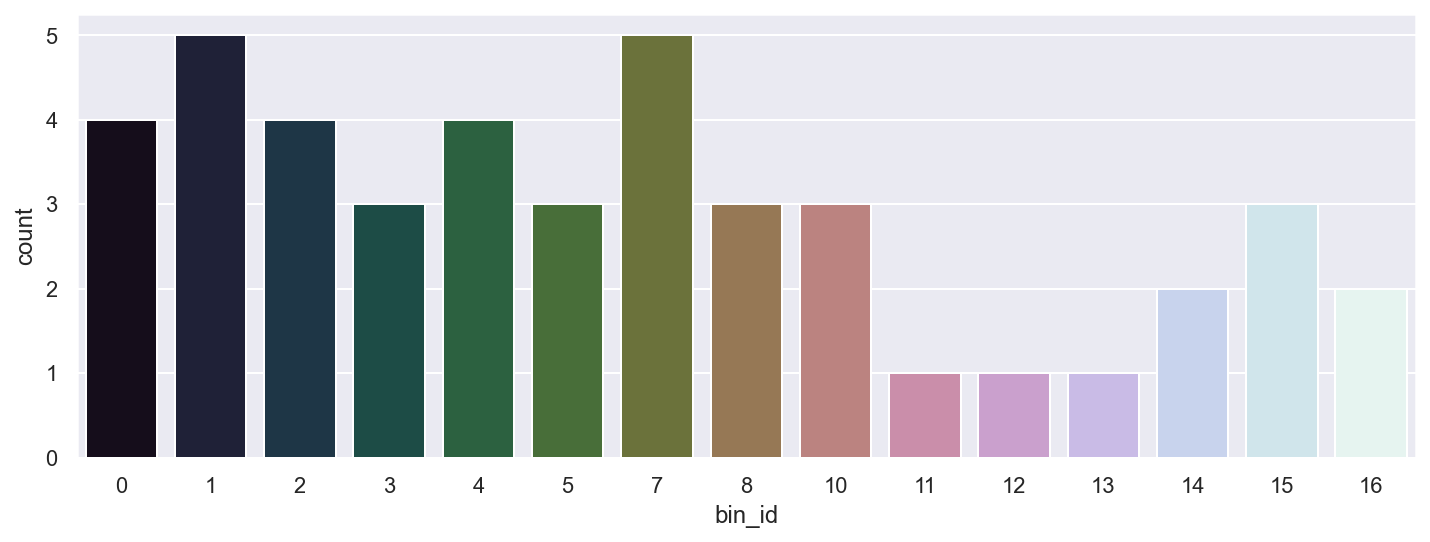

In [8]:
dfp = df.copy()
dfp['bin_id'] = np.digitize(dfp['duration'].values, bin_edges[1:], right=False)
_ = sns.countplot(x='bin_id', data=dfp, palette='cubehelix')

**Observe**

+ All bins are populated, which seems reasonable

---

---

# 2. Packaged Frequentist Model `CoxPHFitter`

Despite it not being our focus here, lets see what the frequentist max-likelihood model in `lifelines` can do for us. 
As seen in earlier notebooks, it gives ease-of-use with internal data transformations, formula specification and for 
CoxPH, penalized regression. All quite useful.

## 2.1 Fit Model

NOTE:

+ We apply a small L2 penalization factor to discourage overfit
+ This L2 penalization is automatic in the Bayesian models because we use Normal priors on the covariates

In [9]:
cx = sa.CoxPHFitter(alpha=0.06, penalizer=0.05, l1_ratio=0.0,
                baseline_estimation_method='piecewise', breakpoints=bin_edges)
_ = cx.fit(df, duration_col='duration', event_col='death', formula="met", show_progress=True)

Optimization terminated successfully.
         Current function value: 3.509026
         Iterations: 37
         Function evaluations: 39
         Gradient evaluations: 39
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.50902602172593
        x: [-5.777e+00  3.629e-01 ... -4.611e-01 -4.256e-01]
      nit: 37
      jac: [ 7.809e-06 -1.429e-06 ...  8.927e-07  1.952e-06]
 hess_inv: [[ 6.907e+00 -2.455e+00 ... -1.194e+00 -1.471e+00]
            [-2.455e+00  1.497e+00 ...  1.205e-01  1.864e-01]
            ...
            [-1.194e+00  1.205e-01 ...  6.108e+00  4.557e+00]
            [-1.471e+00  1.864e-01 ...  4.557e+00  5.174e+00]]
     nfev: 39
     njev: 39


#### Inference

In [10]:
cx.print_summary()

model,lifelines.CoxPHFitter
duration col,'duration'
event col,'death'
penalizer,0.05
l1 ratio,0.0
location of breaks,"[0.0, 14.0, 28.0, 42.0, 56.0, 70.0, 84.0, 98.0..."
baseline estimation,piecewise
number of observations,44
number of events observed,26
log-likelihood,-154.40
time fit was run,2024-11-18 13:56:22 UTC


**Observe:**

+ The summary is most interested in model inference, and provides an estimate for `met=True` of $\hat{\beta_{met}} = 0.81 \in [-0.06, 1.68]_{CI94}$
+ Referring back to our **proportional hazard** formula above, and reminding that we're dealing with a 
  [single boolean covariate `met`](https://en.wikipedia.org/wiki/Proportional_hazards_model#A_single_binary_covariate)

$$
\begin{aligned}
\frac{\hat\lambda(t | \mathbf{x}=1)}{\hat\lambda(t | \mathbf{x}=0)} &= \frac{\lambda_{0}(t) \exp(\beta\cdot 1)}{\lambda_{0}(t) \exp(\beta \cdot 0)} \\
& = \exp(\beta(1-0)) \\
& = \exp(\beta)
\end{aligned}
$$

+ So $\hat{\lambda(t | met=True)} = 2.24 \in [0.94, 5.34]_{CI94}$, which the summary actually helpfully printed for us
+ Stated in words, the estimated hazard rate when `met=True` is `2.24x` the baseline hazard rate, which is broadly in 
  agreement with our observations of the Exponential Regression model(s) in $\S2$ above.
+ We can view this as a plot:

## 2.2 View fitted values

### Plot fitted coefficients and outputs

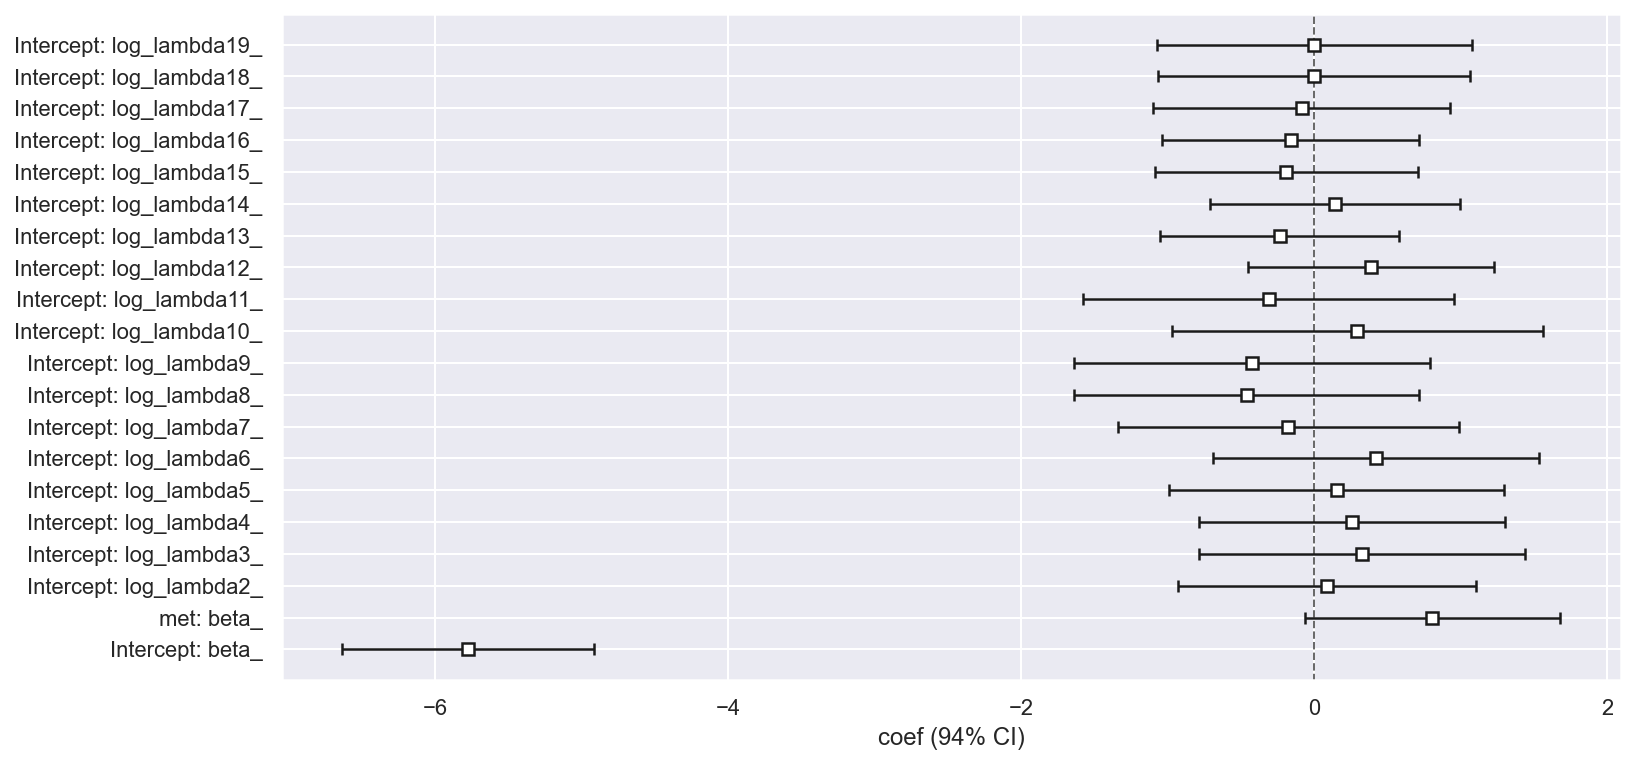

In [11]:
f = plt.figure(figsize=(12, 6))
_ = cx.plot()

We can also plot the baseline hazard function $\lambda_{0}$, and for comparison, plot the `Nelson-Aalen` empirical 
estimate of hazard underneath.
Recall the Nelson-Aalen model directly calculates the empirical cumulative hazard function $\Lambda(t)$, 
so $\lambda(t)$ is available, as opposed to Kaplen-Meier where the concept doesn't directly exist

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/lifelines/fitters/nelson_aalen_fitter.py:246: RuntimeWarning: invalid value encountered in divide
  self.ci_labels[0]: hazard_ * np.exp(z * std_hazard_ / hazard_),
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/lifelines/fitters/nelson_aalen_fitter.py:247: RuntimeWarning: invalid value encountered in divide
  self.ci_labels[1]: hazard_ * np.exp(-z * std_hazard_ / hazard_),


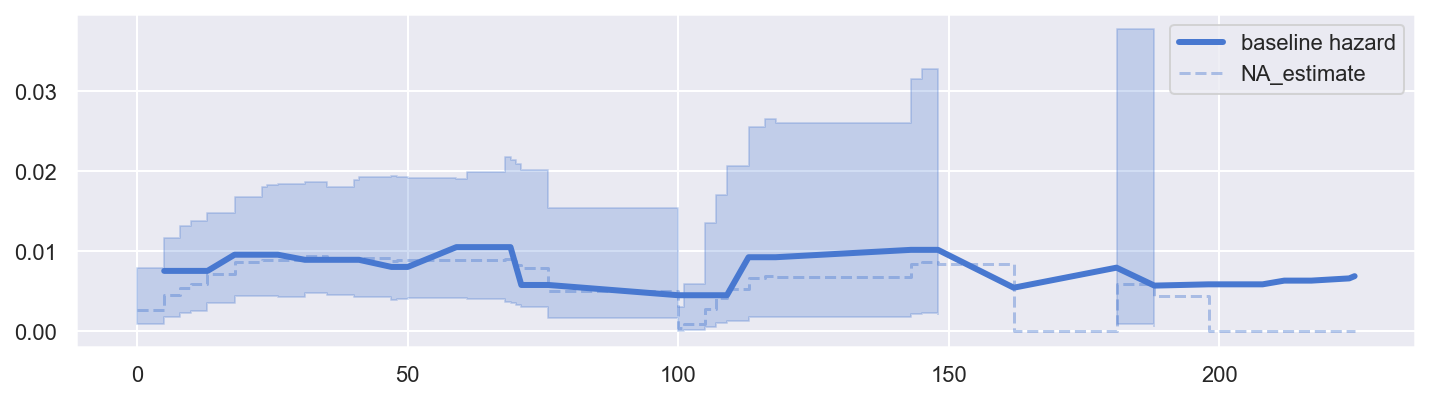

In [12]:
_ = cx.baseline_hazard_.plot(figsize=(12, 3), lw=3)
na = sa.NelsonAalenFitter(alpha=0.05, nelson_aalen_smoothing=False)
na.fit(durations=df['duration'], event_observed=df['death'])
ax = na.plot_hazard(bandwidth=14, color='C0', alpha=0.4, linestyle='--')

**Observe:**

+ The Cox PH piecewise $\lambda_{0}$ varies over time $t$, and correlates nicely with the (totally empirical) estimate from the NA model

### Predict estimated Expected time-to-event $\hat{\mathbb{E}}_{t}$

For illustration and continued comparison, we will predict (on the in-sample dataset) the expected time-to-event 
$\hat{\mathbb{E}}_{t}$ for 2 datapoints which describe the feature space of $\text{met} \in [\text{True}, \text{False}]$

Specifically:
+ `p0 -> met = False`
+ `p12 -> met = True`

In [13]:
print(cx.predict_expectation(df.loc[['p0', 'p12']]))

p0     151.718832
p12    101.269733
dtype: float64


/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/lifelines/fitters/__init__.py:2507: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)


**Observe:**

+ The estimates for the `CoxPH` model are pretty close to `ExponentialRegression` model, which is reassuring
+ Due to the different model architectures, they're difficult to directly compare (e.g. via log-likelihood) and so 
  evaluating which yields the "better" estimates of $\hat{\pi}(t)$ is difficult beyond the scope of this notebook.
+ In general we would choose the model architecture based on the limitations of the data and the inference desired
+ When we switch to the Bayesian model, we still wont be able to compare log-likelihoods between the parametric vs 
  semi-parametric architectures but we will comment upon the difference in the posterior predictive distributions of 
  $\hat{\pi}(t)$ and the relative performance of LOO-PIT and the ECDF plots. Much more powerful.

---

---

# 3. Custom Bayesian Model `CoxPH0`

Here we demonstrate a simple model `CoxPH0` which has an unpooled baseline hazard $\lambda_{0}$ and unpooled static 
covariates $\beta$. This is the closest analog to the frequentist CoxPH model that we will make during this project.

We will improve on this in the __30x_Piecewise family__ series of notebooks with several innovations:

+ `CoxPH1` which has a partially-pooled (aka hierarchial aka mixed-random-effects) baseline hazard $\lambda_{0}$ and 
  unpooled static covariates $\beta$. The partial pooling constrains $\lambda_{0}$ toward a group mean, encouraging 
  a more robust fit
+ `CoxPH2` which has a partially-pooled (hierarchial), strictly ordinal time-dependent baseline hazard $\lambda_{0}$ 
  and unpooled static covariates $\beta$. The partial-pooling constrains $\lambda_{0}$ toward a group mean, 
  encouraging a more robust fit, and the ordinal sequencing is achieved using a `GaussianRandomWalk` which further 
  constrains movements in $\lambda_{0}$ to be proximate.
+ `CoxPH3` which has a partially-pooled (hierarchial), strictly ordinal time-dependent baseline hazard $\lambda_{0}$ 
  and partially-pooled (hierarchial), strictly ordinal time-dependent coefficients $\beta$. This will let us comment
  upon the time-based effect of `met`.

## 3.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use this transformed dataset `dfx` 
in all subsequent models where possible

NOTE:

+ For this example Notebook we will _not_ partition into train & holdout sets
  (see `README.md ## 5. Data Standards` for terminology)
+ Instead we will simply fit the entire dataset and evaluate in-sample using
  Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ This means we still follow our standard process for preparation, 
  transformation, standardization, but abbreviate to `dfa` only


In-house preferred process (transformation, standardization) to create `dfx` for model usage 

In [14]:
dfx_creator = utils.ProjectDFXCreator()
dfx = dfx_creator.get_dfx(df)
eda.describe(dfx)

,3,30,36,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p3,p30,p36,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,70,76,118,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death_t_true,0,0,1,int64,0,0.0,18.0,NaN,NaN,NaN,26.0,0.59,0.5,0.0,0.0,1.0,1.0,1.0
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,44.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
met_t_true,0,1,1,int64,0,0.0,12.0,NaN,NaN,NaN,32.0,0.73,0.45,0.0,0.0,1.0,1.0,1.0


'Shape: (44, 5), Memsize 0.0 MB'

### Further transform `dfx` into the specific forms we need for the piecewise linear regression

We've actually already built this transformation into the model class, but showing it here for completeness

In [15]:
y = dfx['duration'].values
print(f"dur max: {y.max()}")
m = 0 if STEP == 1 else 1
bin_edges = STEP * np.arange((y.max() // STEP) + 1 + m)
print(f'nintervals: {len(bin_edges)}')
print(bin_edges)
jid = np.digitize(y, bin_edges[1:], right=True)
print(jid.max())
jid

dur max: 225
nintervals: 18
[  0  14  28  42  56  70  84  98 112 126 140 154 168 182 196 210 224 238]
16


array([ 1,  3,  4,  4,  7,  7, 10, 12, 14, 14, 15, 15,  0,  0,  0,  0,  1,
        1,  1,  1,  2,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  7,  7,  7,
        8,  8,  8, 10, 10, 11, 13, 15, 15, 16])

#### Create $t_{ij}$

Step 1: create the indicators

In [16]:
# corrected Austin's broadcasting to put False in the correct bin
tid = np.full((len(dfx), jid.max() + 2), True, dtype=np.bool_)
print(tid.shape)
np.put_along_axis(tid, jid.reshape(-1, 1) + 1, False, axis=1)
tid = tid[:, :-1]
tid = np.minimum.accumulate(tid, axis=1)
print(tid.shape)

(44, 18)
(44, 17)


Verify an example

In [17]:
tid[-1:]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True]])

Step 2: Fill with $j$ interval value and calculate the remainder $t = \tau_{j-1}$ on the ragged edge cells

In [18]:
t = tid * STEP
rem_complete = np.mod(y, STEP)
rem_complete[rem_complete == 0] = STEP

np.put_along_axis(t, jid.reshape(-1, 1), rem_complete.reshape(-1, 1), axis=1)
print(t.shape)

(44, 17)


Verify an example

In [19]:
print(t[-1].sum())
t[-1]

225


array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  1])

#### Create $d_{ij}$

In [20]:
e = dfx['death_t_true'].values
d = np.full_like(t, False, dtype=np.bool_)
np.put_along_axis(d, jid.reshape(-1, 1), e.reshape(-1, 1), axis=1)
d.shape

(44, 17)

#### verify example rows

In [21]:
ids = [11, 43, 7]
dfx.iloc[ids]

,duration,death_t_true,intercept,met_t_true
pid,,,,
p11,224,0,1.0,0
p43,225,0,1.0,1
p7,181,1,1.0,0


In [22]:
print(t[ids, :])
print(d[ids, :])

[[14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  0]
 [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  1]
 [14 14 14 14 14 14 14 14 14 14 14 14 13  0  0  0  0]]
[[False False False False False False False False False False False False
  False False False False False]
 [False False False False False False False False False False False False
  False False False False False]
 [False False False False False False False False False False False False
   True False False False False]]


## 3.1 Build Model Object

`CoxPH0` model imported from `src.model.exponential.py` where it is fully defined

In [23]:
mdl_cox0 = exponential.CoxPH0(obs=dfx, fts_en=dfx_creator.fts_en, 
                factor_map=dfx_creator.factor_map, bin_width=STEP, obs_nm='dfx')
mdl_cox0.build()
utils.display_rvs(mdl_cox0)
mdl_cox0.debug()

'RVs for coxph0, v1.2.0, dfx'

lambda_j ~ Gamma(2, f())

beta ~ Normal(0, 2)

shat_ij ~ Deterministic(f(lambda_j, beta))

point={'lambda_j_log__': array([-5.29831739, -5.29831739, -5.29831739, -5.29831739, -5.29831739,
       -5.29831739, -5.29831739, -5.29831739, -5.29831739, -5.29831739,
       -5.29831739, -5.29831739, -5.29831739, -5.29831739, -5.29831739,
       -5.29831739, -5.29831739]), 'beta': array([0.])}

No problems found
point={'lambda_j_log__': array([-5.29831739, -5.29831739, -5.29831739, -5.29831739, -5.29831739,
       -5.29831739, -5.29831739, -5.29831739, -5.29831739, -5.29831739,
       -5.29831739, -5.29831739, -5.29831739, -5.29831739, -5.29831739,
       -5.29831739, -5.29831739]), 'beta': array([0.])}

No problems found


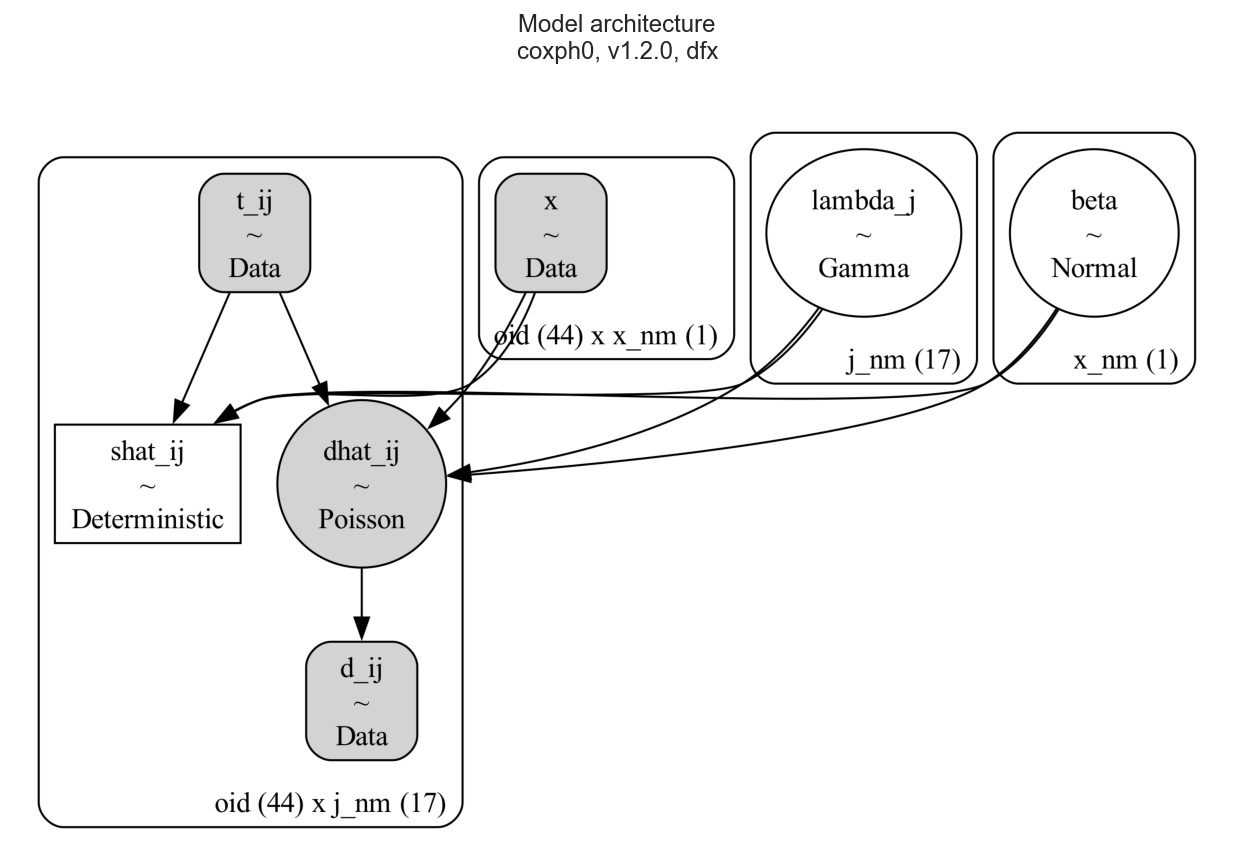

In [24]:
fqn = mdlio.write_graph(mdl_cox0)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdl_cox0.mdl_id}', figsize=(12, 6))

## 3.2 Sample Prior Predictive, View Diagnostics

In [25]:
mdl_cox0.sample_prior_predictive(var_names=mdl_cox0.rvs_lam + mdl_cox0.rvs_b + mdl_cox0.rvs_ppc, replace=True)

#### Evaluate PPC vs In-Sample Data

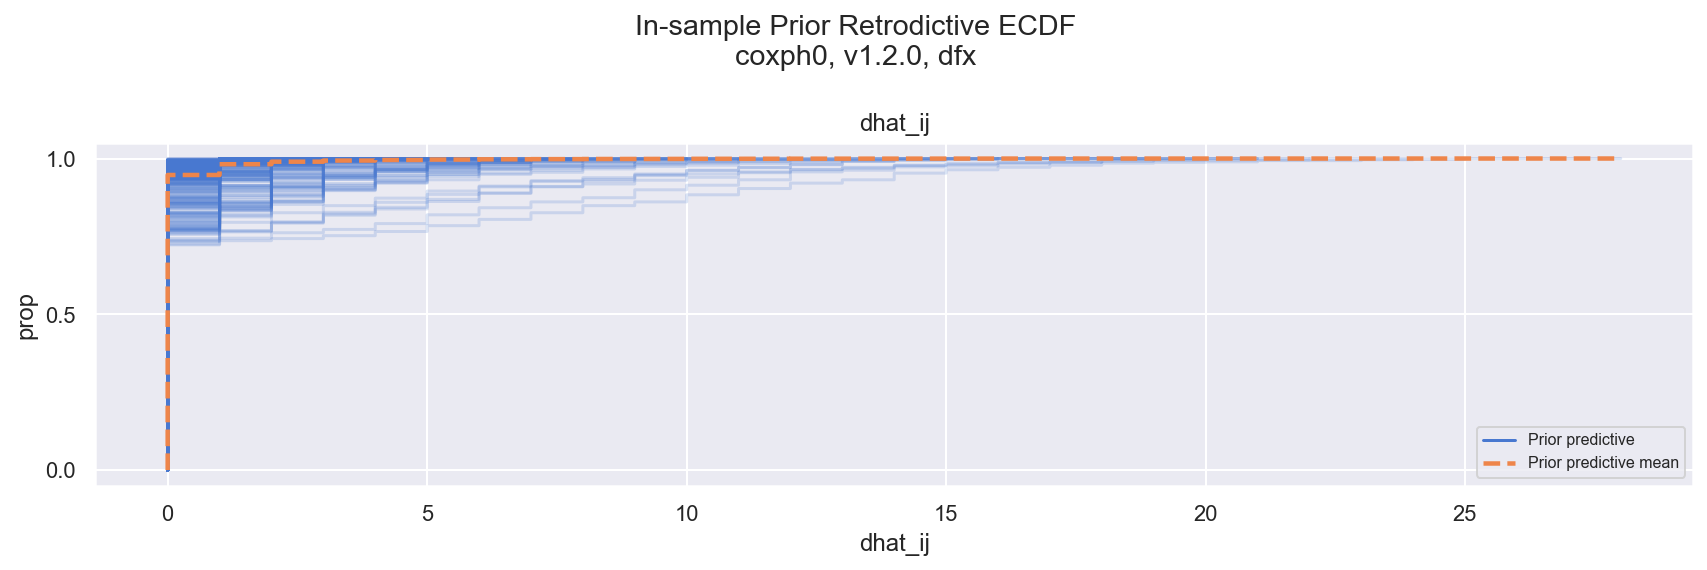

In [26]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdl_cox0, group=GRP, var_names=['dhat_ij'], insamp=True)

**Observe:**

+ Terrible fit as expected, but the range is technically valid considering its Poisson

#### Evaluate priors and hyperpriors

Baseline hazard function $\lambda_{0}$

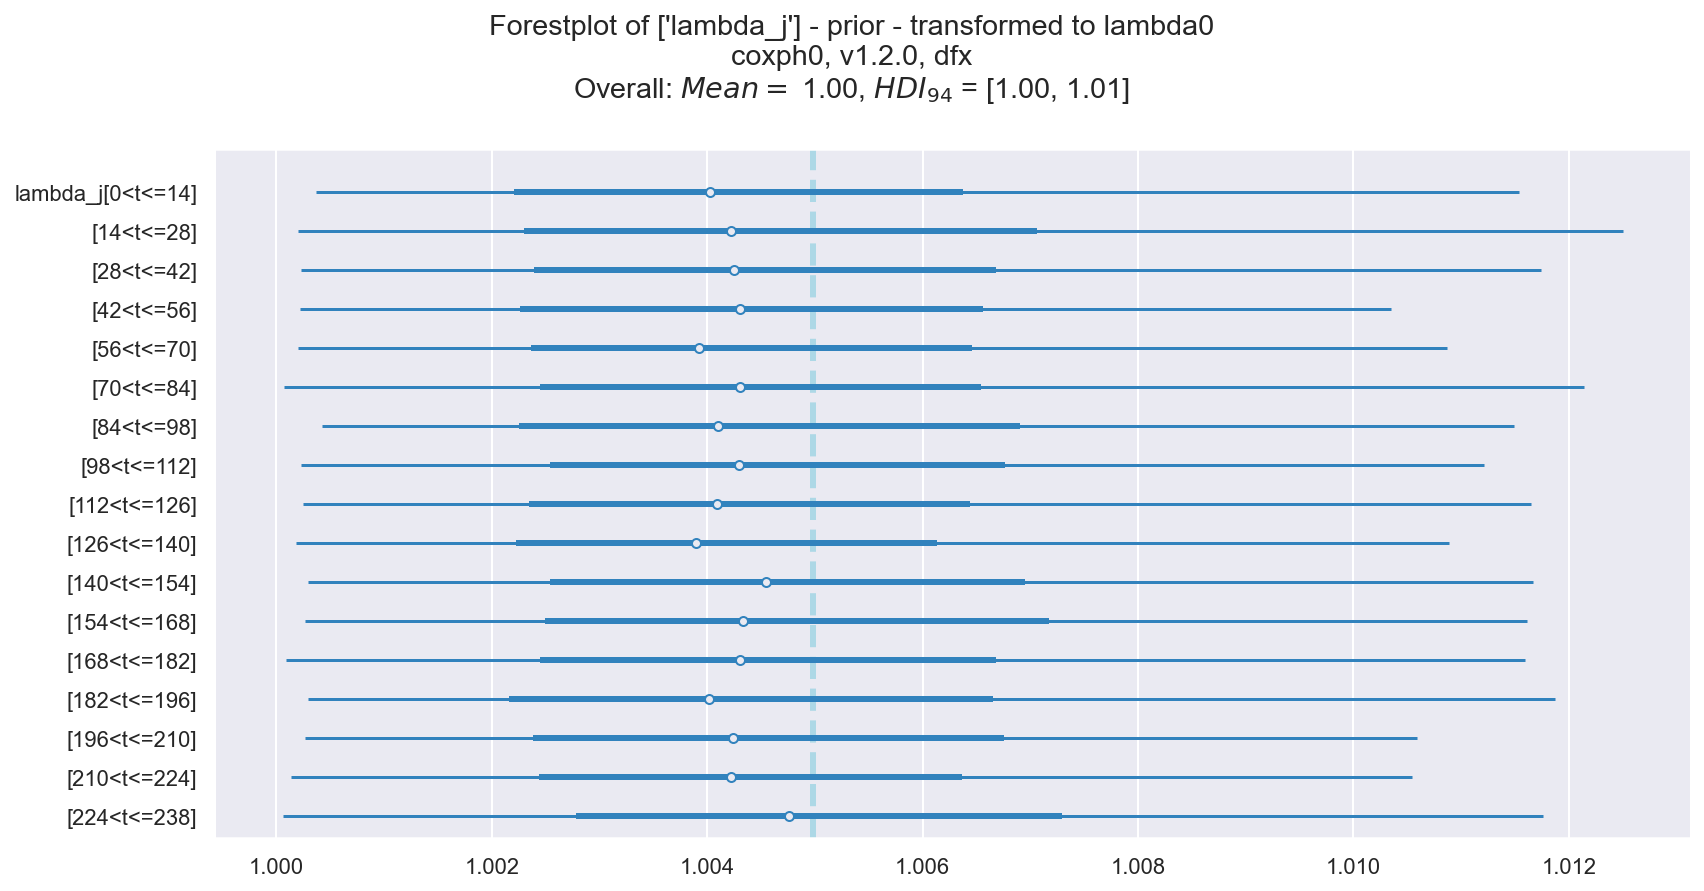

In [27]:
f = mt.forestplot_single(mdl=mdl_cox0, var_names=['lambda_j'], group=GRP, plot_combined=True, 
            transform=np.exp, txtadd='transformed to lambda0')

**Observe**

+ No effect (as specified) with fairly narrow but sufficient `HDI94`s

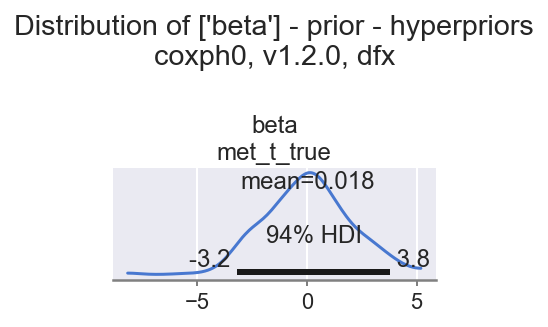

In [28]:
f = mt.facetplot_krushke(mdl=mdl_cox0, group=GRP, txtadd='hyperpriors', rvs=mdl_cox0.rvs_b)

**Observe:**

+ Nice wide HDI94 span centered on 0 (no effect)

## 3.3 Sample Posterior, View Diagnostics

NOTE: also write samples to file so we can reload them later (i.e. in other notebooks to allow for PPC comparison)

In [29]:
mdl_cox0.sample(progressbar=True)
mdl_cox0.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdl_cox0.rvs_ppc)
mdlio.write_idata(mdl=mdl_cox0)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_survival/data/models/idata_coxph0_v120_dfx.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_j[0<t<=14],0.005,0.002,0.002,0.009,0.000,0.000,3349.0,1749.0,1.00
lambda_j[14<t<=28],0.006,0.003,0.002,0.011,0.000,0.000,3221.0,1782.0,1.01
lambda_j[28<t<=42],0.006,0.003,0.002,0.010,0.000,0.000,3179.0,1485.0,1.00
lambda_j[42<t<=56],0.005,0.002,0.001,0.009,0.000,0.000,2931.0,1518.0,1.00
lambda_j[56<t<=70],0.007,0.003,0.002,0.012,0.000,0.000,2626.0,1461.0,1.00
lambda_j[70<t<=84],0.004,0.002,0.000,0.008,0.000,0.000,3065.0,1400.0,1.00
lambda_j[84<t<=98],0.003,0.002,0.000,0.006,0.000,0.000,2976.0,1146.0,1.00
lambda_j[98<t<=112],0.003,0.002,0.000,0.006,0.000,0.000,2784.0,1266.0,1.00
lambda_j[112<t<=126],0.006,0.003,0.001,0.012,0.000,0.000,3686.0,1388.0,1.01
lambda_j[126<t<=140],0.003,0.002,0.000,0.007,0.000,0.000,3185.0,1440.0,1.00


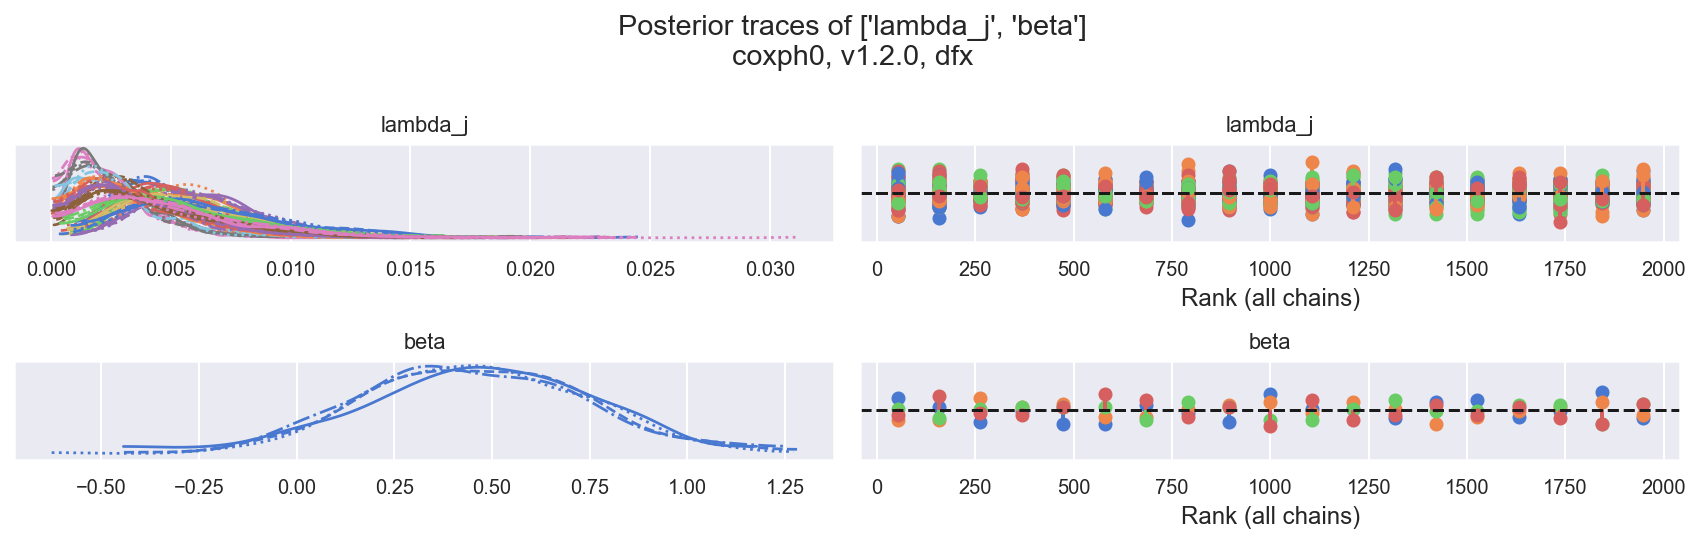

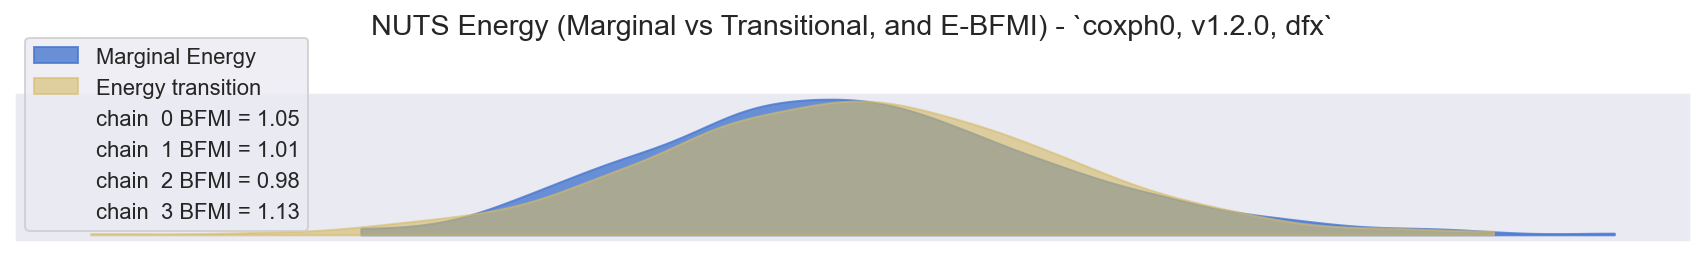

In [30]:
f = mt.plot_trace(mdl=mdl_cox0, rvs=mdl_cox0.rvs_lam + mdl_cox0.rvs_b)
f = mt.plot_energy(mdl=mdl_cox0)
smry = mt.get_summary(mdl=mdl_cox0, rvs=mdl_cox0.rvs_lam + mdl_cox0.rvs_b)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 3.4 Evaluate Posterior PPC (In-Sample) via ECDF

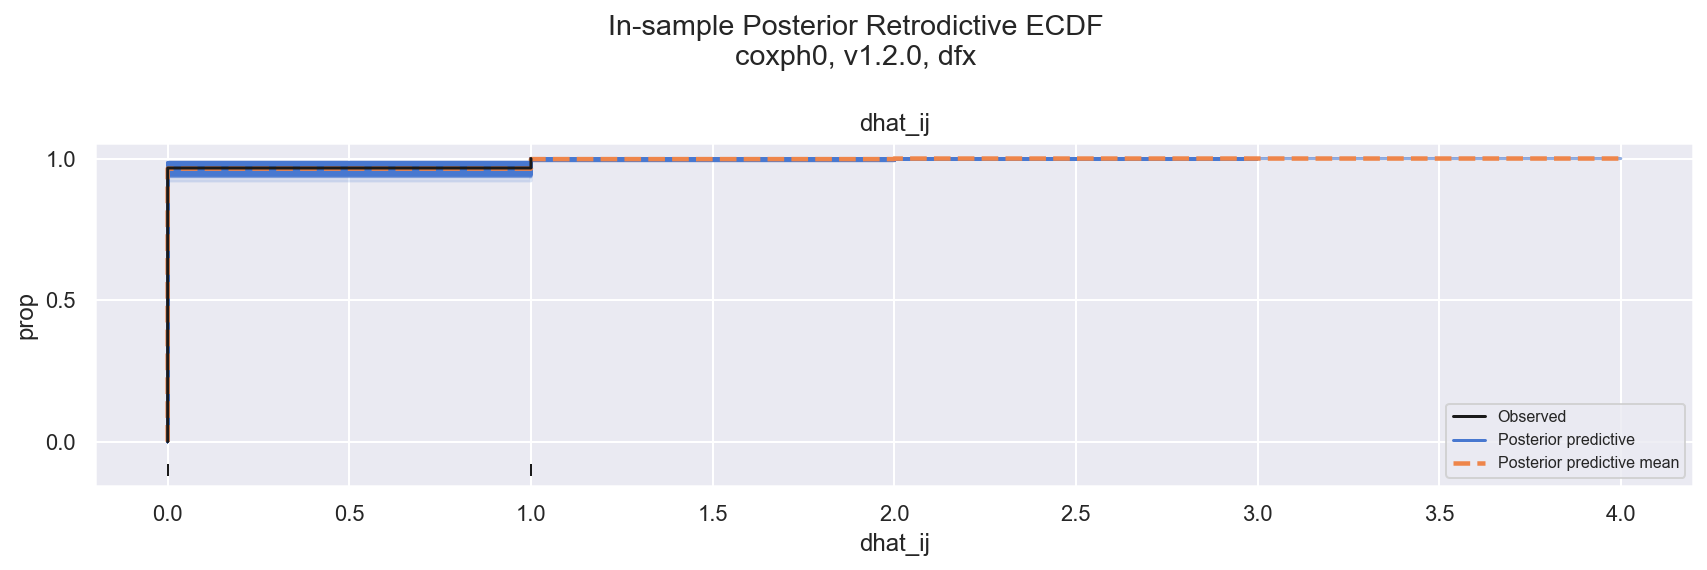

In [31]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdl_cox0, group=GRP, var_names=['dhat_ij'], insamp=True)

**Observe:**

+ This is a pretty nice fit, tight around the real observations $d \in \{0, 1\}$
+ There's still (inevitably) non-zero PPC mass at $d \gt 1$, which is not valid given the problem-space definition (can't die more than $1x$ in an interval!)

## 3.5 Evaluate via LOO-PIT plots (In-Sample)

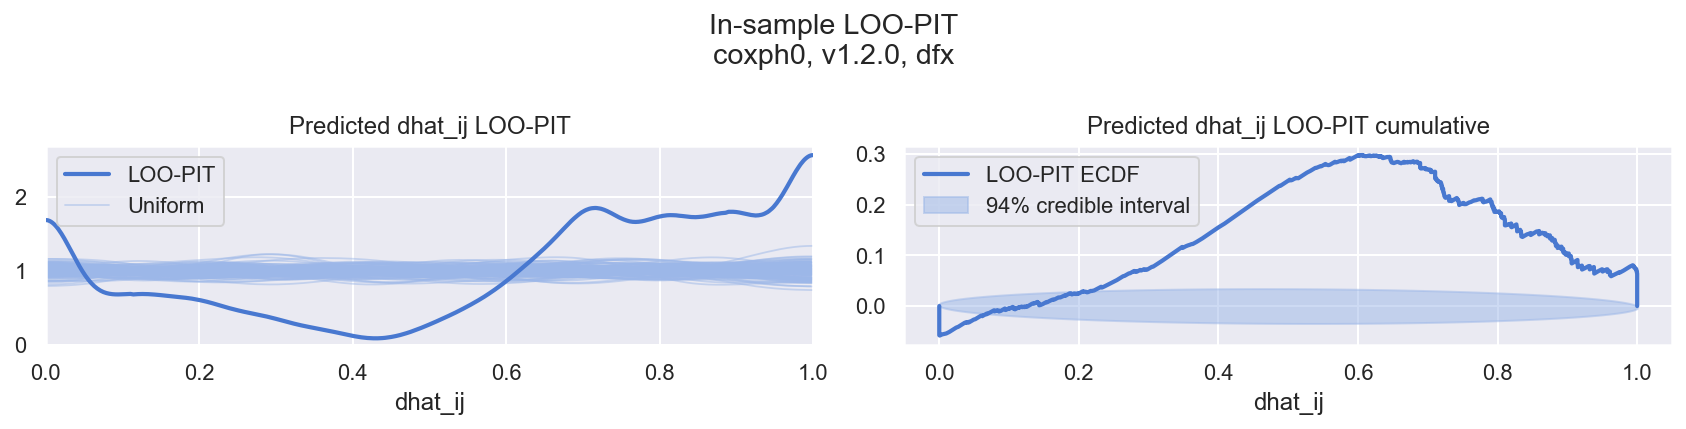

In [32]:
f = mt.plot_loo_pit(mdl_cox0, data_pairs={'dhat_ij': 'dhat_ij'})

**Observe**

+ This LOO-PIT report indicates a poor fit, with underdispersion and bias
+ This isn't a surprise given that the Poisson likelihood has mass at $d > 1$, and in order to minimize that, has
  probably placed too much mass on $0$.

### ~~3.6 Compare Log-Likelihood vs other models~~

NOTE:

+ Not possible here because the shape of the model and variables is not the same as the `exponential_*` models
+ It will be possible to compare with new CoxPH architectures in later notebooks

In [33]:
# None

## 3.7 Evaluate Posterior Parameters

### 3.7.1 baseline hazard function $\lambda_{0}$

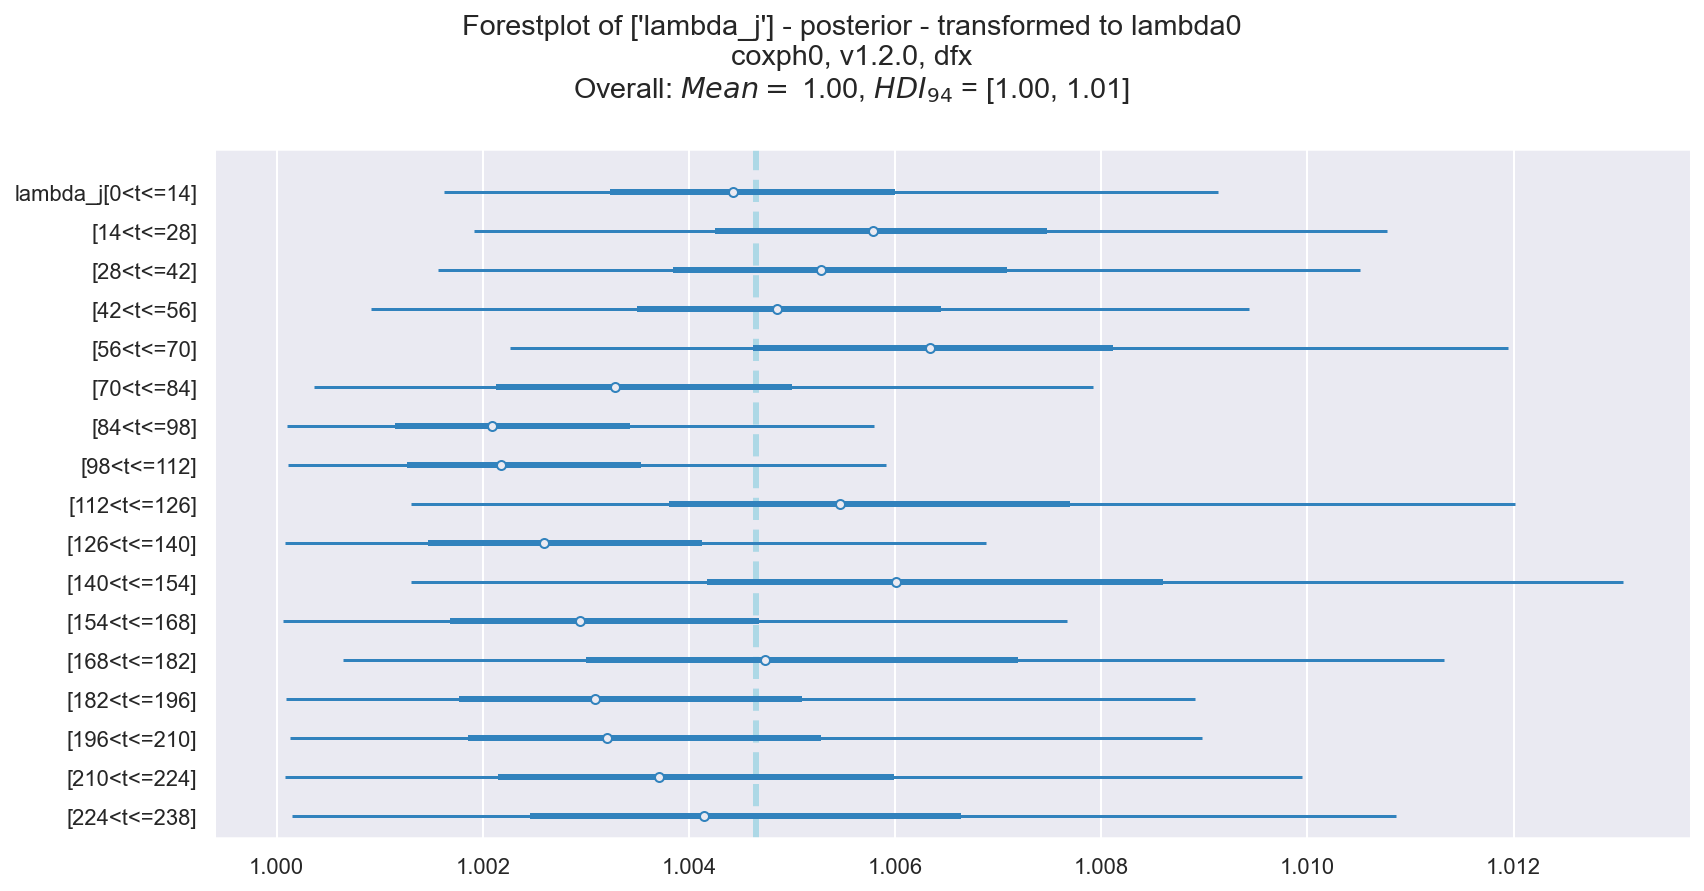

In [34]:
f = mt.forestplot_single(mdl=mdl_cox0, var_names=['lambda_j'], group=GRP, combined=True, 
            transform=np.exp, txtadd='transformed to lambda0')

**Observe:**

+ Posteriors look reasonable and we see the effect of allowing $\lambda_{0}$ to vary across time interval
+ Because in `mdl_cox0` this is an unpooled parameter, each interval value floats independently, notable timesteps are:
  + `[14 < t_ij <= 28]` and `[56 < t_ij <= 70]`: higher mortality
  + `[84 < t_ij <= 98]` and `[98 < t_ij <= 112]`: lower mortality
+ In the real-world, this infinite degree of freedom seems unlikely to be valid, because since time is ordered and trends
  should be more smooth, possibly monotonic, possibly bi- or tri-modal, but unlikely infinitely-modal
+ We will improve this on a subsequent model

### 3.7.2 Hyperpriors `beta`

We transform `beta` to `exp(beta)`, which for this simple dataset gets us the proportional hazard of `met=True`

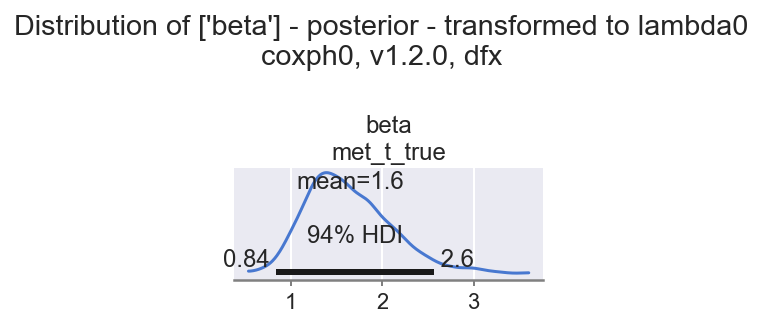

In [35]:
# f = mt.facetplot_krushke(mdl=mdl_cox0, group=GRP, rvs=mdl_cox0.rvs_b)
f = mt.facetplot_krushke(mdl=mdl_cox0,group=GRP, rvs=mdl_cox0.rvs_b, transform=np.exp, txtadd='transformed to lambda0')

**Observe**

+ Here `beta: met_t_true` carries the value for `met=True`, and shows substantial bulk away from zero, implying a strong effect
+ So $\hat{\lambda(t | met=True)} = 1.60 \in [0.84, 2.60]_{HDI94}$, this is much better defined than the Frequentist 
  model above (which estimated $\hat{\lambda(t | met=True)} = 2.24 \in [0.94, 5.34]_{CI94}$)

> Stated in words, the estimated hazard rate when `met=True` is `1.60x` the baseline hazard rate, which is broadly in 
> agreement with our observations of the exponential regression model in `101_Exponential_Regression.ipynb`

## 3.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

Because this model is semi-parametric, we can **forecast** Survival $\hat{S}(j)$ for observations in an **out-of-sample dataset**

However, unlike the fully parametric models:
+ We don't get Expected Time-to-Event "for free" out of the model, because it doesnt have the concept of $\hat{\mathbb{E}}_{t} \sim S^{-1}(u)$
+ Instead, we have to interpolate $\hat{\mathbb{E}}_{t} \sim \int_{0}^{t_{max}} dt \ S(t)$

> See the full detailed discussion in `100_Exponential_Univariate.ipynb` $\S3.8$

### 3.8.1 Create synthetic dataset, calc PPC and extract PPC components

In [36]:
dfs = utils.get_synthetic_df_oos(df, is_coxph=True)
dfsx = dfx_creator.get_dfx(dfs, in_sample=False)

mdl_cox0.replace_obs(obsd={'obs': dfsx}, obs_nm='dfsx')
mdl_cox0.build()
f_idata = mdl_cox0.sample_posterior_predictive(store_ppc=False, ppc_insample=True, var_names=mdl_cox0.rvs_ppc)
dfhat = utils.get_ppc_components_as_dfm(f_idata, getx=True, is_coxph=True, j_nm=mdl_cox0.coords['j_nm'])
dfp = pd.merge(dfhat, dfs.reset_index(), how='left', left_on='oid', right_on='pid')
eda.display_ht(dfp)

Output()

,oid,j_nm,chain,draw,shat_ij,dhat_ij,oid_sub,t_ij,t,tau_min,tau_max,met_t_true,pid,met,death,duration
0,z000,0<t<=14,0,0,0.97,0,z000,14,14,0,14,0,z000,False,False,225
1,z000,0<t<=14,0,1,0.99,0,z000,14,14,0,14,0,z000,False,False,225
2,z000,0<t<=14,0,2,0.87,0,z000,14,14,0,14,0,z000,False,False,225
67997,z001,224<t<=238,3,497,0.18,0,z001,1,225,224,238,1,z001,True,False,225
67998,z001,224<t<=238,3,498,0.23,0,z001,1,225,224,238,1,z001,True,False,225
67999,z001,224<t<=238,3,499,0.19,0,z001,1,225,224,238,1,z001,True,False,225


'Shape: (68000, 16), Memsize 8.7 MB'

### 3.8.2 Plot estimated Survival $\hat{S}(j)$ at intervals $j$ and $\hat{S}(t)$ as interpolated smooth $t$

NOTE:

+ The CoxPH model operates on ordinal intervals $j$, so we must distinguish between predictions $\hat{S}(j)$ vs $\hat{S}(t)$
+ We plot $\hat{S}(j)$ as ordinal points and make no attempt to interpolate time
+ We plot $\hat{S}(t)$ as lines with linearly interpolated time

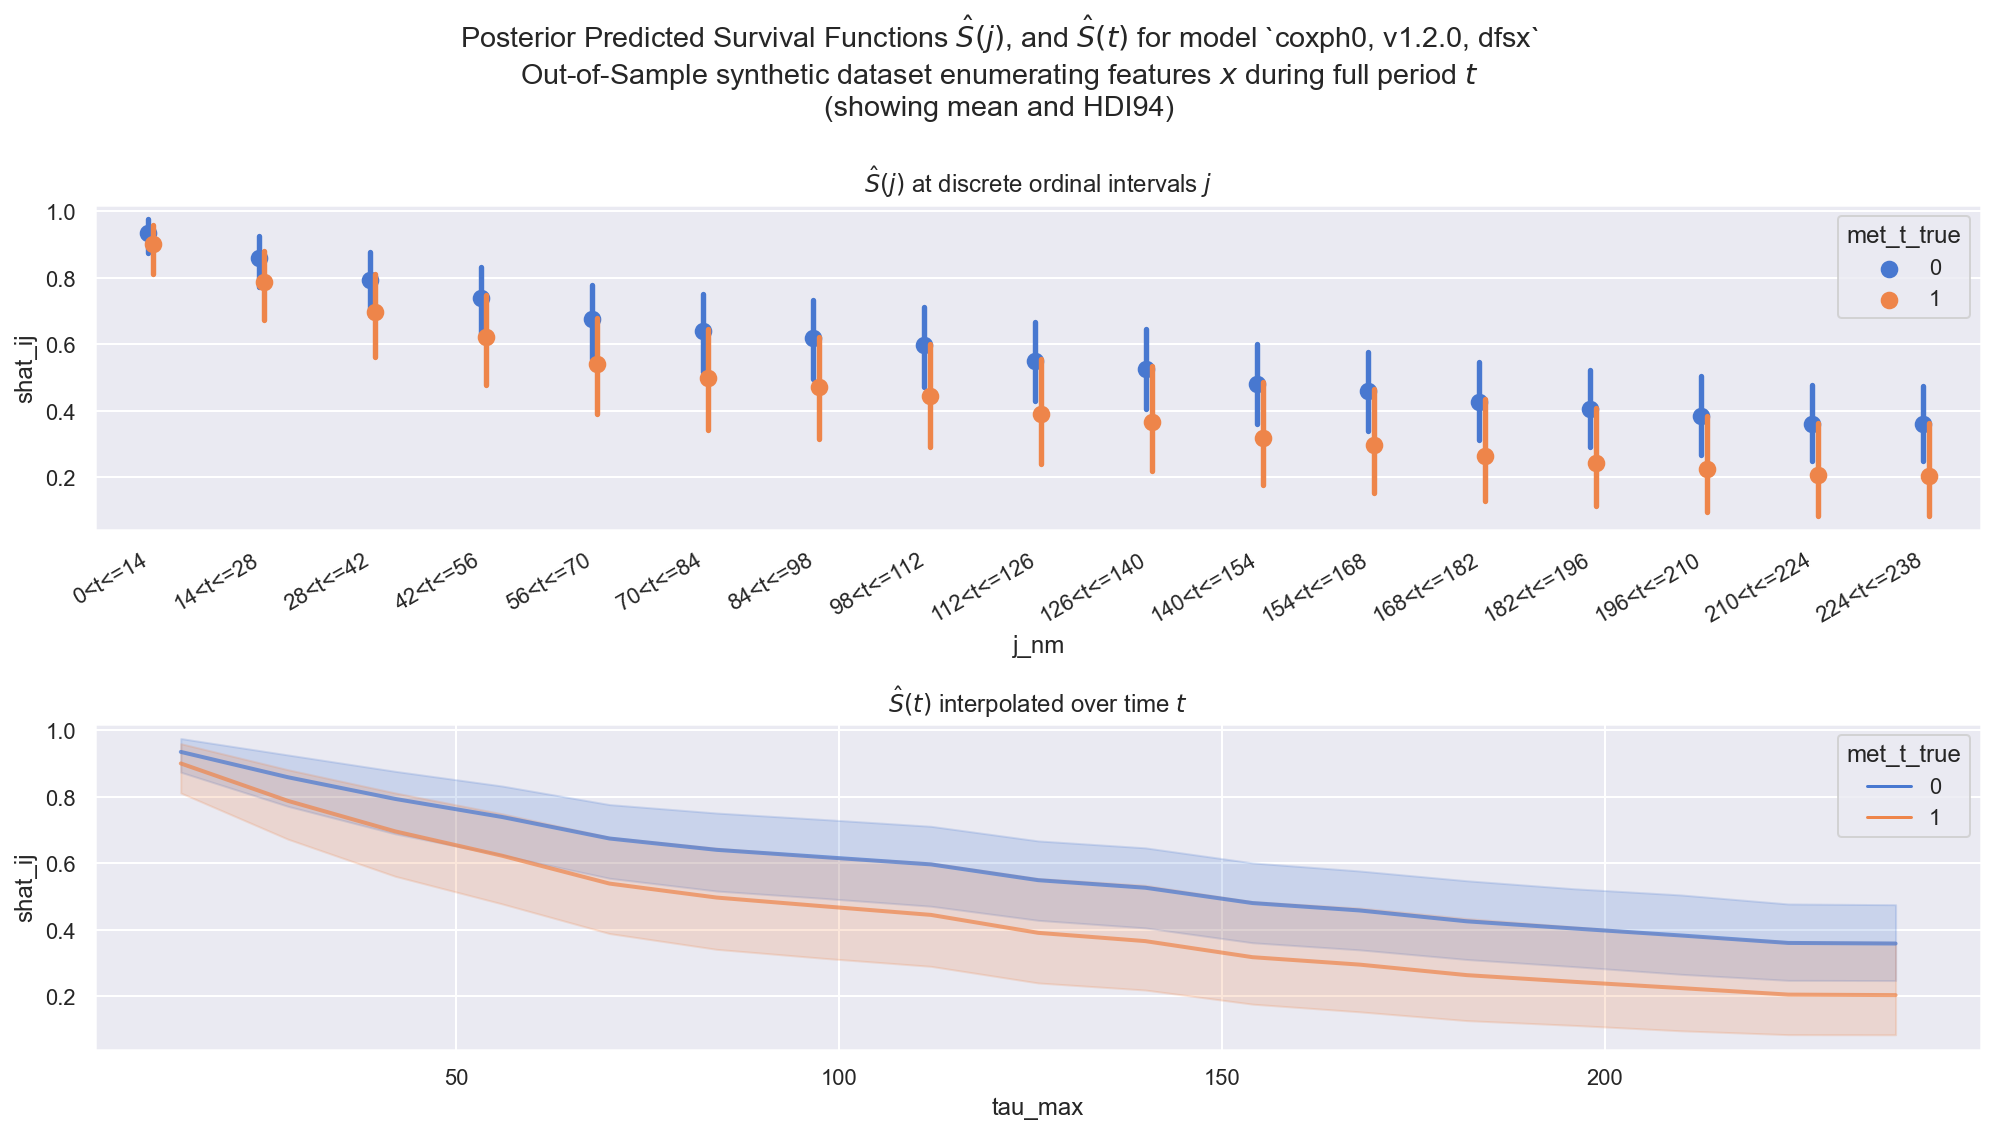

In [37]:
f, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
ax0 = sns.pointplot(x='j_nm', y='shat_ij', hue='met_t_true', data=dfp, join=False, dodge=True, ax=axs[0], 
                    estimator='mean', errorbar=('pi', 94))
_ = ax0.set_xticklabels(ax0.get_xticklabels(), rotation=30, ha='right')
_ = ax0.set_title('$\hat{{S}}(j)$ at discrete ordinal intervals $j$')
ax1 = sns.lineplot(x='tau_max', y='shat_ij', hue='met_t_true', data=dfp, style='met_t_true', ms=10, dashes=False, alpha=0.7, 
                legend=True, lw=2, ax=axs[1], estimator='mean', errorbar=('pi', 94), err_style='band')
_ = ax1.set_title('$\hat{{S}}(t)$ interpolated over time $t$')
_ = f.suptitle(f'Posterior Predicted Survival Functions $\hat{{S}}(j)$, and $\hat{{S}}(t)$ for model `{mdl_cox0.mdl_id}`'
    + '\nOut-of-Sample synthetic dataset enumerating features $x$ during full period $t$'
    + '\n(showing mean and HDI94)')
_ = f.tight_layout()
fqn = figio.write(f, fn=f'102_{mdl_cox0.mdl_id}_forecast_shat')

**Observe:**

+ Even though we saw a reasonably distinguishing value for $\hat{\lambda(t | met=True)} = 1.70 \in [0.82, 2.60]_{CR94}$,
  the combination with $\hat{\lambda_{0}}(t)$ leads to posterior predictions of $\hat{S}(t)$ that have substantial
  overlap between groups `met`
+ As we saw above, $\hat{\lambda_{0}}(t)$ has such span that it's taking explanatory power from `\beta`. In forthcoming
  models below we will require $\hat{\lambda_{0}}(t)$ to be more tightly defined via a hierarchical structure

### 3.8.3 Expected time-to-event $\hat{\mathbb{E}}_{t}$

We integrate the curve $\hat{S}(t)$ assuming linearly interpolated time

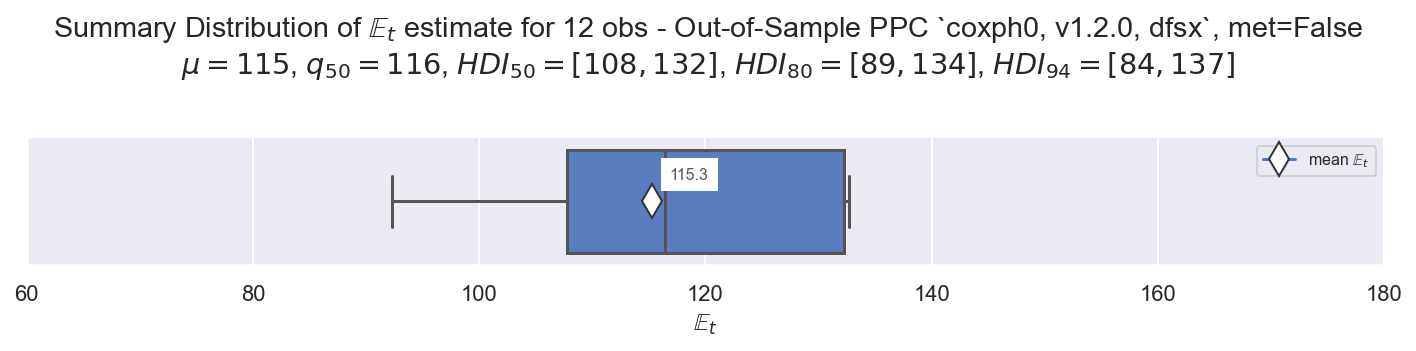

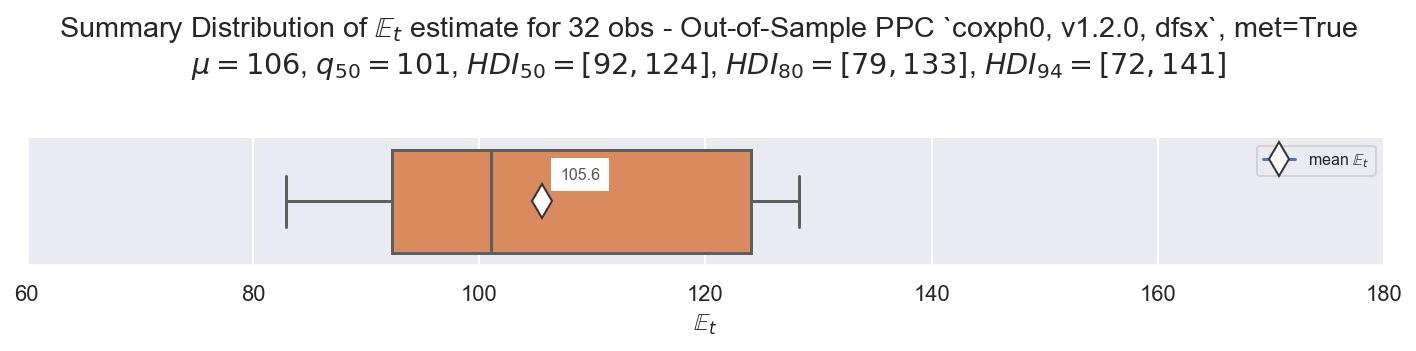

In [38]:
df_et = dfp.groupby(['oid_sub', 'chain', 'draw', 'met_t_true'])\
            .apply(lambda g: np.trapz(y=g['shat_ij'], x=g['tau_max']), include_groups=False)\
            .to_frame('$\mathbb{E}_{t}$')
            
f = eda.plot_estimate(df=df_et.loc[:, :, 0], nobs=len(dfx) - dfx['met_t_true'].sum(), yhat='$\mathbb{E}_{t}$',
    txtadd=f'Out-of-Sample PPC `{mdl_cox0.mdl_id}`, met=False',force_xlim=(60, 180))
fqn = figio.write(f, fn=f'102_{mdl_cox0.mdl_id}_forecast_et_met_false')

f = eda.plot_estimate(df=df_et.loc[:, :, 1],nobs=dfx['met_t_true'].sum(), yhat='$\mathbb{E}_{t}$',
    txtadd=f'Out-of-Sample PPC `{mdl_cox0.mdl_id}`, met=True', color='C1', force_xlim=(60, 180))
fqn = figio.write(f, fn=f'102_{mdl_cox0.mdl_id}_forecast_et_met_true')

**Observe:**

+ Now here's the distribution of forecasted expected survival times $\mathbb{E}_{t}$ for our **synthetic out-of-sample dataset**
  + For `met = False`: $\mathbb{E}_{t} \sim 115 \in [84, 137]_{HDI94}$ days
  + For `met = True`: $\mathbb{E}_{t} \sim 106 \in [72, 141]_{HDI94}$ days
+ These empirical predicted distributions have substantial degree of overlap
+ These results continue to broadly agree with our Exponential models to date

---

---

# Notes

In [39]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 17:57:05

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

pymc    : 5.16.2
pytensor: 2.25.5

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

lifelines : 0.30.0
pyprojroot: 0.3.0
seaborn   : 0.12.2
sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
oreum_core: 0.9.7
pandas    : 2.2.3
matplotlib: 3.9.2
numpy     : 1.26.4



---
**Oreum OÜ &copy; 2024**